In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER


## Requirements

In [3]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


     |████████████████████████████████| 3.8 MB 30.0 MB/s 
     |████████████████████████████████| 895 kB 57.8 MB/s 
     |████████████████████████████████| 77 kB 8.6 MB/s 
     |████████████████████████████████| 596 kB 65.4 MB/s 
     |████████████████████████████████| 6.5 MB 59.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Import & Config

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch

In [6]:
MODELNAME = 'biobert-base-cased'

In [7]:
MODEL_PATH = 'dmis-lab/biobert-base-cased-v1.1'

In [8]:
tokenizer_name = 'bert-base-cased'

In [9]:
num_train_epochs = 5
if 'dist' in MODEL_PATH:
  num_train_epochs=3 # distil BERT usually needs less epoch than full bert

In [10]:
num_train_epochs

5

In [11]:
print(MODEL_PATH)

dmis-lab/biobert-base-cased-v1.1


## Dataset Preprocessing


Dataset config file

In [12]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/"

root_data_dir = os.path.join(root_dir, "datasets", "BiodivNER")

dataset = "train"
train_csv_file_path = "train.csv"
val_csv_file_path = "dev.csv"
test_csv_file_path = "test.csv"

Data loading utils

In [13]:
def loadData(csv_file_path):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1")
  data = data.fillna(method="ffill")
  return data

In [14]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),                                                          
                                                        s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [15]:
data = loadData(train_csv_file_path)

In [16]:
data.head(10)

,Sentence #,Word,Tag
0,Sentence: 0,Samplenr,O
1,Sentence: 0,Seedlingnr,O
2,Sentence: 0,Plot,O
3,Sentence: 0,Record,O
4,Sentence: 0,Date,O
5,Sentence: 0,Planted_Species,O
6,Sentence: 0,Density,B-Quality
7,Sentence: 0,Treatment,B-Phenomena
8,Sentence: 0,Dead,B-Quality
9,Sentence: 0,Height_P,O


In [17]:
val_data = loadData(val_csv_file_path)

In [18]:
val_data.offset = 465
val_data.head(10)

,Sentence #,Word,Tag
0,Sentence: 0,For,O
1,Sentence: 0,live,B-Organism
2,Sentence: 0,snags,I-Organism
3,Sentence: 0,the,O
4,Sentence: 0,measurement,O
5,Sentence: 0,height,B-Quality
6,Sentence: 0,is,O
7,Sentence: 0,indicated,O
8,Sentence: 0,by,O
9,Sentence: 0,a,O


In [19]:
test_data =  loadData(test_csv_file_path)

In [20]:
test_data.head(10)

,Sentence #,Word,Tag
0,Sentence: 0,Combining,O
1,Sentence: 0,metabolic,O
2,Sentence: 0,and,O
3,Sentence: 0,food-,O
4,Sentence: 0,web,O
5,Sentence: 0,theory,O
6,Sentence: 0,",",O
7,Sentence: 0,we,O
8,Sentence: 0,calculate,O
9,Sentence: 0,annual,O


Preparation of VOCAB and tags lists

In [21]:
#if the data are in string style, we propably use tokenzer.fit_on_texts instead of list manipulation like here

VOCAB = list(set(list(data["Word"].values) + \
                 list(val_data["Word"].values) + \
                 list(test_data["Word"].values)))
VOCAB.append("ENDPAD")

n_words = len(VOCAB) #n_words includes all vocab from train and validation test.

tags = list(set(data["Tag"].values))

n_tags = len(tags)


In [22]:
print(n_words, VOCAB[0:10] ,VOCAB[n_words-1], sep='\n')

9158
['comparing', 'inclination.The', 'brood_stock', 'subplots', 'sample_2_2', 'Ailanthus', 'northwest', 'restricting', 'clusters', 'considerable']
ENDPAD


In [23]:
print(n_tags, tags, sep='\n')

13
['B-Matter', 'I-Organism', 'O', 'B-Organism', 'I-Quality', 'I-Location', 'I-Matter', 'I-Environment', 'B-Quality', 'B-Location', 'B-Phenomena', 'I-Phenomena', 'B-Environment']


### Data Explortion

Creating sentences for train, val and test sets.

In [24]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [25]:
getter_val = SentenceGetter(val_data)
sentences_val = getter_val.sentences

In [26]:
getter_test = SentenceGetter(test_data)
sentences_test = getter_test.sentences

In [27]:
sent = getter_test.get_next()
print(sent)

[('The', 'O'), ('primacy', 'O'), ('of', 'O'), ('either', 'O'), ('species', 'B-Quality'), ('or', 'O'), ('functional', 'O'), ('group', 'O'), ('richness', 'B-Quality'), ('effects', 'O'), ('depended', 'O'), ('on', 'O'), ('the', 'O'), ('sequence', 'O'), ('of', 'O'), ('testing', 'O'), ('these', 'O'), ('terms', 'O'), (',', 'O'), ('indicating', 'O'), ('that', 'O'), ('both', 'O'), ('aspects', 'O'), ('of', 'O'), ('richness', 'B-Quality'), ('were', 'O'), ('congruent', 'O'), ('and', 'O'), ('complementary', 'O'), ('to', 'O'), ('expected', 'O'), ('strong', 'O'), ('effects', 'O'), ('of', 'O'), ('legume', 'O'), ('presence', 'O'), ('and', 'O'), ('grass', 'B-Organism'), ('presence', 'O'), ('on', 'O'), ('plant', 'B-Organism'), ('chemical', 'B-Quality'), ('composition', 'I-Quality'), ('.', 'O')]


Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. after running the below cells, we will find that COPIOUS has longer sentences than BERT which means it will trim them.

In [28]:
plt.style.use("ggplot")

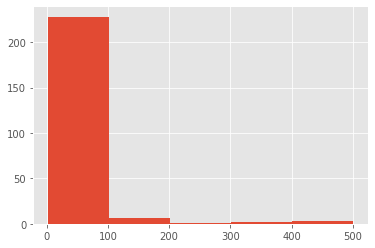

In [29]:
plt.hist([len(s) for s in sentences_val], bins=5)
plt.show()

In [30]:
max([len(s) for s in sentences_val]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

500

### Encoder Format

Encoder/Decoder dictonaries for tags

In [31]:
tag2id = {tag: id for id, tag in enumerate(tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

Split texts from tags (use two different python lists)

In [32]:
def get_text_tags_lists(sentences):
  texts = []
  tags = []
  for sent in sentences: #list of tuples    
    sent_texts = []
    sent_tags = []  
    for tuple1 in sent:  
      sent_texts.append(tuple1[0])
      sent_tags.append(tuple1[1])

    texts.append(sent_texts)
    tags.append(sent_tags)
  return texts, tags

In [33]:
train_texts, train_tags = get_text_tags_lists(sentences)
val_texts, val_tags = get_text_tags_lists(sentences_val)
test_texts, test_tags = get_text_tags_lists(sentences_test)

In [34]:
max([len(s) for s in train_texts])

1053

## BioBERT Model

In [35]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)
  
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
test_encodings = tokenizer(test_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Handling mismatch between tokens (OOV of BERT), since COPIUS has words that are not in BERT's VOCAB, and encoded labels. We do that by keeping the first token encoding and ignoring the rest, set them to -100 each.

### Label Mismatch Solution

In [36]:
def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):      
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        #since we enabled the truncation=ture in the encoding, we should handle this again in the labels
        max_len = len(doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)]) 

        # set labels whose first offset position is 0 and the second is not 0 
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels[0:max_len]

    
        encoded_labels.append(doc_enc_labels.tolist())
    return encoded_labels

In [37]:
train_labels = encode_tags(train_tags, train_encodings)

In [38]:
val_labels = encode_tags(val_tags, val_encodings)

In [39]:
test_labels = encode_tags(test_tags, test_encodings)

### Inspect

In [40]:
tag2id

{'B-Environment': 12,
 'B-Location': 9,
 'B-Matter': 0,
 'B-Organism': 3,
 'B-Phenomena': 10,
 'B-Quality': 8,
 'I-Environment': 7,
 'I-Location': 5,
 'I-Matter': 6,
 'I-Organism': 1,
 'I-Phenomena': 11,
 'I-Quality': 4,
 'O': 2}

In [41]:
len(train_encodings['input_ids'])

1918

In [42]:
for i in train_encodings['input_ids'][0:3]:
  print(len(i), i)

512 [101, 2687, 7136, 1179, 1197, 3969, 21869, 1179, 1197, 153, 7841, 7992, 14265, 9646, 1174, 168, 11763, 14760, 13730, 19165, 5620, 21621, 168, 153, 21621, 168, 144, 21825, 168, 26997, 21825, 168, 8732, 21825, 168, 5620, 8732, 2553, 168, 5250, 139, 2660, 23749, 168, 12855, 139, 2660, 23749, 168, 12219, 5619, 1104, 23103, 1116, 1104, 1103, 2233, 7411, 1107, 1142, 2233, 9388, 14384, 7886, 12737, 119, 5840, 1580, 1604, 13176, 119, 17474, 1495, 1853, 119, 24053, 1477, 1853, 119, 7393, 1559, 1604, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 4551, 1361, 168, 176, 1200, 14044, 2087, 27750, 1200, 6869, 5217, 28009, 131, 3969, 21869, 1901, 7886, 118, 3213, 1105, 25128, 23749, 2233, 1799, 1884, 11708, 1776, 7008, 1107, 2582, 3611, 1110, 3933, 3716, 1118, 3154, 1104, 9100, 20545, 16416, 1158, 117, 1103, 4945, 10947, 118, 18354, 113, 147, 118, 140, 114, 11066, 1110, 1126, 4174, 3136, 1115, 1144, 1151, 4260, 1112, 170, 1558, 14769, 6978, 10100, 1344, 1530, 3987

In [43]:
for i in train_labels[0:3]: # each row is 512 values
  print(len(i), i)

512 [-100, 2, -100, -100, -100, 2, -100, -100, -100, 2, -100, 2, 2, 2, -100, -100, -100, 8, -100, 10, 8, 2, -100, -100, 2, -100, -100, 2, -100, -100, 2, -100, -100, 2, -100, -100, 2, -100, -100, -100, 2, -100, -100, -100, -100, 2, -100, -100, -100, -100, 2, 2, 2, -100, 2, 2, 2, 2, 2, 2, 2, -100, 2, 2, 2, -100, -100, -100, -100, 2, -100, -100, -100, 2, -100, -100, -100, 2, -100, -100, -100, -100, 2, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, -100, 2, -100, -100, -100, 2, 12, 2, 2, 3, -100, 2, 2, 2, 10, 2, 8, -100, 2, 2, 2, -100, -100, -100, 2, 12, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, -100, 2, 2, 2, -100, -100, -100, 2, 2, -100, -100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 4, -100, 2, 2, 2, 2, 2, 2, 12, 7, 7, 2, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

### Dataset objects 

Create the dataset objects

In [44]:
class COPIOUSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [45]:
train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")
test_encodings.pop("offset_mapping")

[[(0, 0),
  (0, 2),
  (2, 4),
  (4, 9),
  (0, 9),
  (0, 3),
  (0, 4),
  (4, 5),
  (0, 3),
  (0, 6),
  (0, 1),
  (0, 2),
  (0, 9),
  (0, 6),
  (0, 6),
  (0, 4),
  (4, 6),
  (0, 2),
  (0, 5),
  (0, 7),
  (0, 2),
  (0, 4),
  (4, 5),
  (5, 8),
  (0, 2),
  (2, 6),
  (6, 15),
  (0, 2),
  (0, 5),
  (5, 8),
  (8, 12),
  (0, 9),
  (0, 11),
  (0, 1),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0

In [46]:
train_dataset = COPIOUSDataset(train_encodings, train_labels)
val_dataset = COPIOUSDataset(val_encodings, val_labels)
test_dataset = COPIOUSDataset(test_encodings, test_labels)

### Training

Here, we instantiate the model

In [48]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH, num_labels=len(tags))

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

#### Fine-tuning using Trainer

In [49]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for preds, lbls in zip(predictions, labels):  
      [y_true.append(id2tag[l]) for p, l in zip(preds, lbls) if l != -100]
      [y_pred.append(id2tag[p]) for p, l in zip(preds, lbls) if l != -100]

    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

In [50]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
  )

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1918
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1200


Epoch,Training Loss,Validation Loss,Accuracy
1,0.296300,0.245734,0.924908
2,0.147500,0.153569,0.947348
3,0.138100,0.150125,0.956674
4,0.084300,0.145171,0.956868
5,0.025600,0.153681,0.959200


***** Running Evaluation *****
  Num examples = 240
  Batch size = 64
***** Running Evaluation *****
  Num examples = 240
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 240
  Batch size = 64
***** Running Evaluation *****
  Num examples = 240
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 240
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1200, training_loss=0.2638059057295322, metrics={'train_runtime': 1047.9588, 'train_samples_per_second': 9.151, 'train_steps_per_second': 1.145, 'total_flos': 2506085103298560.0, 'train_loss': 0.2638059057295322, 'epoch': 5.0})

### Save model

In [51]:
model.save_pretrained('{}_BiodivNER'.format(MODELNAME))

Configuration saved in biobert-base-cased_BiodivNER/config.json
Model weights saved in biobert-base-cased_BiodivNER/pytorch_model.bin


### Prediction

The use of validation dataset

In [52]:
eval_history = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 240
  Batch size = 64


In [53]:
predictionsOutput = trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 240
  Batch size = 64


In [54]:
predictionsOutput.predictions.shape

(240, 512, 13)

In [55]:
predictions = predictionsOutput.predictions.argmax(axis=2)

In [56]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(240, 512)

In [57]:
len(test_encodings['input_ids'][0])

512

Explore one example of the test dataset (prediction vs. true) lables.

In [58]:
for tokens, preds, lbls in zip(test_encodings['input_ids'], predictions, test_labels):
  print([(tokenizer.decode(t), id2tag[p]) for t, p, l in zip(tokens, preds, lbls) if l != -100])
  print([(tokenizer.decode(t), id2tag[l]) for t, l in zip(tokens, lbls) if l != -100])
  break

[('Co', 'O'), ('metabolic', 'O'), ('and', 'O'), ('food', 'O'), ('web', 'O'), ('theory', 'O'), (',', 'O'), ('we', 'O'), ('calculate', 'O'), ('annual', 'O'), ('energy', 'O'), ('flux', 'O'), ('to', 'O'), ('model', 'O'), ('impacts', 'O'), ('of', 'O'), ('land', 'B-Quality'), ('in', 'O'), ('on', 'O'), ('multi', 'O'), ('ecosystem', 'B-Environment'), ('functioning', 'O'), ('.', 'O')]
[('Co', 'O'), ('metabolic', 'O'), ('and', 'O'), ('food', 'O'), ('web', 'O'), ('theory', 'O'), (',', 'O'), ('we', 'O'), ('calculate', 'O'), ('annual', 'O'), ('energy', 'O'), ('flux', 'O'), ('to', 'O'), ('model', 'O'), ('impacts', 'O'), ('of', 'O'), ('land', 'B-Phenomena'), ('in', 'I-Phenomena'), ('on', 'O'), ('multi', 'O'), ('ecosystem', 'B-Environment'), ('functioning', 'O'), ('.', 'O')]


### Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [59]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []
for tokens, preds, lbls in zip(test_encodings['input_ids'], predictions, test_labels):  
  [y_true.append(id2tag[l]) for t, p, l in zip(tokens, preds, lbls) if l != -100]
  [y_pred.append(id2tag[p]) for t, p, l in zip(tokens, preds, lbls) if l != -100]

In [60]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.9518716577540107


In [61]:
from classification_metrics import classification_report, replaceMultiple

In [62]:
print(classification_report(y_true, y_pred,exclude_non_entity=True))

                        precision 	 recall 	 f1-score 	 support

B-Matter            	 0.76		 0.52		 0.61		 153	
I-Organism          	 0.78		 0.82		 0.80		 73	
B-Organism          	 0.87		 0.90		 0.88		 305	
I-Quality           	 0.90		 0.89		 0.89		 381	
I-Location          	 0.71		 0.76		 0.74		 33	
I-Matter            	 0.70		 0.57		 0.63		 37	
I-Environment       	 0.68		 0.71		 0.69		 48	
B-Quality           	 0.84		 0.87		 0.86		 414	
B-Location          	 0.77		 0.61		 0.68		 38	
B-Phenomena         	 0.81		 0.85		 0.83		 65	
I-Phenomena         	 0.75		 0.88		 0.81		 24	
B-Environment       	 0.74		 0.75		 0.75		 171	


macro avg           	 0.78		 0.76		 0.77		 1742	
micro avg           	 0.83		 0.82		 0.82		 1742	



In [63]:
y_true = [replaceMultiple(val, ["B-","I-"], "") for val in y_true ]
y_pred = [replaceMultiple(val, ["B-","I-"], "") for val in y_pred ]

In [64]:
print(classification_report(y_true, y_pred,exclude_non_entity=True))

                        precision 	 recall 	 f1-score 	 support

Environment         	 0.80		 0.82		 0.81		 219	
Organism            	 0.87		 0.90		 0.89		 378	
Matter              	 0.80		 0.56		 0.66		 190	
Phenomena           	 0.80		 0.87		 0.83		 89	
Quality             	 0.90		 0.91		 0.91		 795	
Location            	 0.85		 0.77		 0.81		 71	


macro avg           	 0.84		 0.81		 0.82		 1742	
micro avg           	 0.86		 0.85		 0.86		 1742	



### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [65]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

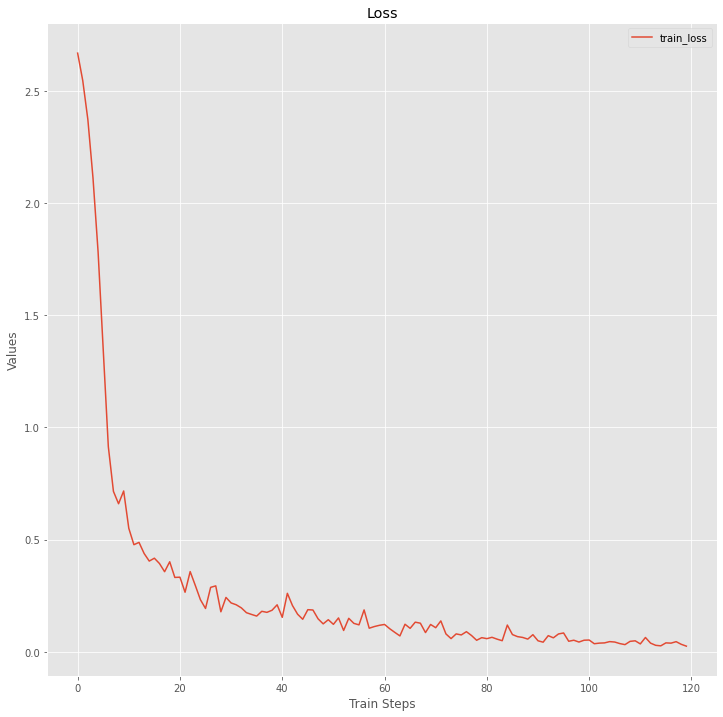

In [66]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    #loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [67]:
eval_history

{'epoch': 5.0,
 'eval_accuracy': 0.9591995337089567,
 'eval_loss': 0.15368077158927917,
 'eval_runtime': 8.5263,
 'eval_samples_per_second': 28.148,
 'eval_steps_per_second': 0.469}

In [68]:
num_train_epochs

5

In [69]:
if 'dist' in MODEL_PATH:
  print('yes')
else:
  print('No')

No


In [70]:
print(tokenizer)


PreTrainedTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
